In [1]:
import random
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import gluon, autograd


In [2]:
batch_size = 512
ctx = mx.gpu() if mx.context.num_gpus() > 0 else mx.cpu()


In [19]:
transform = lambda x,y: (x.transpose((2, 0, 1)).astype('float32')/255.0, y)

train_dataset = gluon.data.vision.FashionMNIST(train=True)
test_dataset = gluon.data.vision.FashionMNIST(train=False)

train_dataset[0][0].shape

6

In [9]:
train_dataset_t = train_dataset.transform(transform)
test_dataset_t = test_dataset.transform(transform)

train_dataset_t

In [10]:
train_data = gluon.data.DataLoader(train_dataset_t, batch_size=batch_size, last_batch='rollover', shuffle=True)
test_data = gluon.data.DataLoader(test_dataset_t, batch_size=batch_size, shuffle=False, last_batch='rollover')


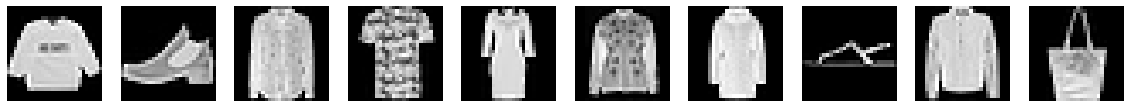

In [11]:
plt.figure(figsize=(20, 10))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    ax.imshow(train_dataset[i][0].squeeze().asnumpy(), cmap='gray')
    ax.axis('off')


In [25]:
net = gluon.nn.HybridSequential()
encoder = gluon.nn.HybridSequential()

encoder.add(
    gluon.nn.Conv2D(channels=4, kernel_size=3, padding=1, strides=(2, 2), activation='relu'),
    gluon.nn.BatchNorm(),
    gluon.nn.Conv2D(channels=8, kernel_size=3, padding=1, strides=(2, 2), activation='relu'),
    gluon.nn.BatchNorm(),
    gluon.nn.Conv2D(channels=16, kernel_size=3, padding=1, strides=(2, 2), activation='relu'),
    gluon.nn.BatchNorm(),
    gluon.nn.Conv2D(channels=32, kernel_size=3, padding=0, strides=(2, 2), activation='relu'),
    gluon.nn.BatchNorm(),

)

decoder = gluon.nn.HybridSequential()
decoder.add(
    gluon.nn.Conv2D(channels=32, kernel_size=3, padding=2, activation='relu'),
    gluon.nn.HybridLambda(lambda F, x: F.UpSampling(x, scale=2, sample_type='nearest')),
    gluon.nn.BatchNorm(),
    gluon.nn.Conv2D(channels=16, kernel_size=3, padding=1, activation='relu'),
    gluon.nn.HybridLambda(lambda F, x: F.UpSampling(x, scale=2, sample_type='nearest')),
    gluon.nn.BatchNorm(),
    gluon.nn.Conv2D(channels=8, kernel_size=3, padding=2, activation='relu'),
    gluon.nn.HybridLambda(lambda F, x: F.UpSampling(x, scale=2, sample_type='nearest')),
    gluon.nn.BatchNorm(),
    gluon.nn.Conv2D(channels=4, kernel_size=3, padding=1, activation='relu'),
    gluon.nn.Conv2D(channels=1, kernel_size=3, padding=1, activation='sigmoid')
)

net.add(
    encoder,
    decoder
)
net

HybridSequential(
  (0): HybridSequential(
    (0): Conv2D(None -> 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), Activation(relu))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (2): Conv2D(None -> 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), Activation(relu))
    (3): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (4): Conv2D(None -> 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), Activation(relu))
    (5): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (6): Conv2D(None -> 32, kernel_size=(3, 3), stride=(2, 2), Activation(relu))
    (7): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  )
  (1): HybridSequential(
    (0): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), Activation(relu))
    (1): HybridLa

In [26]:
net.initialize(ctx=ctx)

In [27]:
net.summary(train_dataset_t[0][0].expand_dims(axis=0).as_in_context(ctx))



--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                              (1, 1, 28, 28)               0
        Activation-1                    <Symbol conv20_relu_fwd>               0
        Activation-2                              (1, 4, 14, 14)               0
            Conv2D-3                              (1, 4, 14, 14)              40
         BatchNorm-4                              (1, 4, 14, 14)              16
        Activation-5                    <Symbol conv21_relu_fwd>               0
        Activation-6                                (1, 8, 7, 7)               0
            Conv2D-7                                (1, 8, 7, 7)             296
         BatchNorm-8                                (1, 8, 7, 7)              32
        Activation-9                    <Symbol conv22_relu_fwd>               0
       Activation-10        